In [180]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from scipy.io import arff
import matplotlib.pyplot as plt

In [181]:
"""Zamiana formatu danych z arff na csv w celu ułatwienia późniejszej pracy"""
data = arff.loadarff('speeddating.arff')
df = pd.DataFrame(data[0])
for attribute in df.columns:
    if df[attribute].dtype == 'object':
        df[attribute] = df[attribute].str.decode('utf-8')

df.to_csv('speeddating.csv', index=False)

In [182]:
"""Tworzę nową ramkę danych z różnicami między parami (różnica wieku, rasy, jak ważna dla ankietowanej osoby jest wspólna rasa,
różnice w ocenie oraz oczekiwaniach atrakcyjności, szczerości, inteligencji, dowcipu, ambicji, wspólnych zainteresowań,
orelacja wspólnych zainteresowań - dane możliwe do uzyskania podczas ankiety przed randką"""
df = pd.read_csv('speeddating.csv')
new_df = pd.DataFrame()
new_data_list = []
for row in df.itertuples():

    difference_age = row[6]
    difference_race = row[10]
    importance_same_race = row[11]
    difference_attractive_imporatance = abs(row[16]-row[40])
    difference_sincere_imporatance = abs(row[17]-row[41])
    difference_intelligence_imporatance = abs(row[18]-row[42])
    difference_funny_imporatance = abs(row[19]-row[43])
    difference_ambition_imporatance = abs(row[20]-row[44])
    difference_shared_interests_imporatance = abs(row[21]-row[45])
    attractive_difference = abs(row[28] - row[52])
    sinsere_difference = abs(row[29] - row[53])
    intelligence_difference = abs(row[30] - row[54])
    funny_difference = abs(row[31] - row[55])
    ambitous_difference = abs(row[32] - row[56])
    interests_correlation = row[108]
    target = row[123]

    new_data = {
        'difference_age': difference_age,
        'difference_race': difference_race,
        'importance_same_race': importance_same_race,
        'difference_attractive_imporatance': difference_attractive_imporatance,
        'difference_sincere_imporatance': difference_sincere_imporatance,
        'difference_intelligence_imporatance': difference_intelligence_imporatance,
        'difference_funny_imporatance': difference_funny_imporatance,
        'difference_ambition_imporatance': difference_ambition_imporatance,
        'difference_shared_interests_imporatance': difference_shared_interests_imporatance,
        'attractive_difference': attractive_difference,
        'sinsere_difference': sinsere_difference,
        'intelligence_difference': intelligence_difference,
        'funny_difference': funny_difference,
        'ambitous_difference': ambitous_difference,
        'interests_correlation': interests_correlation,
        'target': target
    }
    new_data_list.append(new_data)

new_df = pd.DataFrame(new_data_list)
new_df.to_csv('df_differences.csv', index=False)

In [183]:
"""Sprawdzę jak wyglądają dane"""

'Sprawdzę jak wyglądają dane'

In [184]:
print(new_df.head())
print(new_df.describe())
print(new_df["target"].value_counts())
print(new_df.info())
print(new_df.isnull().sum())
print(new_df.dropna(inplace=True))
print(new_df.info())

   difference_age  difference_race  importance_same_race   
0             6.0                0                   2.0  \
1             1.0                0                   2.0   
2             1.0                1                   2.0   
3             2.0                0                   2.0   
4             3.0                0                   2.0   

   difference_attractive_imporatance  difference_sincere_imporatance   
0                               20.0                             0.0  \
1                               45.0                            20.0   
2                                4.0                             2.0   
3                               15.0                            15.0   
4                               15.0                            10.0   

   difference_intelligence_imporatance  difference_funny_imporatance   
0                                  0.0                           5.0  \
1                                 20.0                        

In [185]:
"""Tworzę pierwszy model - las losowy"""

'Tworzę pierwszy model - las losowy'

In [186]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('target', axis=1), new_df['target'], test_size=0.15)
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy: ", accuracy_score(y_test, y_pred))

accuracy:  0.8342440801457195


In [187]:
"""Dla podanego modelu accuracy wyniosło >0.80, sprawdzę macierz pomyłek"""

'Dla podanego modelu accuracy wyniosło >0.80, sprawdzę macierz pomyłek'

In [188]:
print(confusion_matrix(y_test, y_pred))

[[916   0]
 [182   0]]


In [189]:
"""Jak widać, wynik modelu jest "napompowany" wynikami negatywnymi, nie umie wskazać pozytywnych randek"""
"to pokazuje że accuracy NIE POWINNO być używane do oceny modeli - uczestnik nigdy nie dostanie propozycji randki"
"dla oceny poniższych modeli najważniejsza przyjętą miarą będzie stosunek w ilości sytuacji gdzie model nadał etykietę"
"1 dla danej testowej w której wynikiem faktycznie było 1 do ilości wszystkich danych w których model nadał etykietę 1"
"-chodzi o proponowanie ludziom w pierwszej kolejności takich randek które mają szanse powodzenia i by użytkownik jak najszybciej"
"znalazł odpowiednią osobę"

'znalazł odpowiednią osobę'

In [190]:

for i in range(1,10):
    for j in range(1,10):
        model = RandomForestClassifier(n_estimators=10*i, max_depth=10*j)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("_____________________")
        print("proba: ", i, " ", j)
        print("confusion matrix: ")
        print(confusion_matrix(y_test, y_pred))
        if confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[0][1] == 0:
            print("brak pozytywnych wyników")
        else:
            print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[0][1]))
        print("_____________________")
        print("_____________________")

_____________________
proba:  1   1
confusion matrix: 
[[914   2]
 [179   3]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.6
_____________________
_____________________
_____________________
proba:  1   2
confusion matrix: 
[[900  16]
 [165  17]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.5151515151515151
_____________________
_____________________
_____________________
proba:  1   3
confusion matrix: 
[[903  13]
 [164  18]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.5806451612903226
_____________________
_____________________
_____________________
proba:  1   4
confusion matrix: 
[[906  10]
 [170  12]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.5454545454545454
_____________________
_____________________
_____________________
proba:  1   5
confusion matrix: 
[[892  24]
 [172  10]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.29411764705882354
_____________________
________________

In [191]:
"wyniki są dobre dla parametrów n_estimators = 50 i max_depth = 90  , sprawdzę jeszcze kilka razy czy zawsze są one dobre czy tylko raz się udało dla takiego wylosowania danych"
random_forest_cm_1 = 0
random_forest_score_1 = 0
max = 0
model = RandomForestClassifier(n_estimators=50, max_depth=90)
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(new_df.drop('target', axis=1), new_df['target'], test_size=0.15)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
        random_forest_cm_1 = cm
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if cm[1][1]/(cm[1][1]+cm[0][1]) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            random_forest_score_1 = cm[1][1]/(cm[1][1]+cm[0][1])
            random_forest_cm_1 = cm

_____________________
confusion matrix: 
[[923   3]
 [162  10]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.7692307692307693
_____________________
confusion matrix: 
[[915   5]
 [168  10]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.6666666666666666
_____________________
confusion matrix: 
[[907   1]
 [181   9]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.9


In [192]:
"Jako porównanie sprawdzimy jak poradzi sobie nadawanie etykiet losowo, proporcjonalnie do częstości występowania etykiet w danych"
"oraz jakie są szanse gdyby użytkownik miał pójść na randkę z jakąkolwiek osobą"
dummy_cm_1 = 0
dummy_score_1 = 0
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
print("_____________________")
print("losowo ale z proporcjami")
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
if cm[1][1]+cm[0][1] == 0:
    print("brak pozytywnych wyników")
else:
    print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
    dummy_score_1 = cm[1][1]/(cm[1][1]+cm[0][1])
dummy_cm_1 = cm

_____________________
losowo ale z proporcjami
confusion matrix: 
[[758 150]
 [156  34]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.18478260869565216


In [193]:
"Z jednej strony wyniki modelu opartego o las losowy są znacznie lepsze niż przy losowym " \
"doborze poprzez klasyfikator 'Dummy', jednak mając zbiór ponad 1000 danych proponuje tylko około" \
"10 randek, co oznacza że aplikacja musiała by mieć bardzo dużą bazę użytkowników, żeby w ogóle działała"
"Teraz dla porównania spróbuję wytrenować sieć neuronową"

'Teraz dla porównania spróbuję wytrenować sieć neuronową'

In [226]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["Precision"])

model.fit(X_train, y_train, epochs=5, batch_size=4 , class_weight={0:1, 1:1}, ) #, class_weight=class_weights)


Epoch 1/5
2980/2980 [==============================] - 4s 1ms/step - loss: 0.5960 - precision: 0.6561
Epoch 2/5
2980/2980 [==============================] - 3s 1ms/step - loss: 0.5535 - precision: 0.6904
Epoch 3/5
2980/2980 [==============================] - 4s 1ms/step - loss: 0.5276 - precision: 0.7185
Epoch 4/5
2980/2980 [==============================] - 4s 1ms/step - loss: 0.5072 - precision: 0.7291
Epoch 5/5
2980/2980 [==============================] - 4s 1ms/step - loss: 0.4860 - precision: 0.7408


In [227]:
y_pred = model.predict(X_test)
sequential_cm_1 = 0
sequential_score_1 = 0
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
print("_____________________")
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
if cm[1][1]+cm[0][1] == 0:
    print("brak pozytywnych wyników")
    sequential_cm_1 = cm
else:
    print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
    sequential_cm_1 = cm
    sequential_score_1 = cm[1][1]/(cm[1][1]+cm[0][1])

40/40 [==============================] - 0s 923us/step
_____________________
confusion matrix: 
[[878 160]
 [178  41]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.20398009950248755


In [196]:
"""Przy wielu parametrach sieć ulega bardzo szybkiemu przetrenowaniu, niestety zwykle w stronę
nadmiernego oznaczanie wszystkich danych jako negatywne"""
"""Sprawdzę jeszcze czy istnieje możliwość stworzenia modelu w oparciu o maszynę wektorów nośnych"""

'Sprawdzę jeszcze czy istnieje możliwość stworzenia modelu w oparciu o maszynę wektorów nośnych'

In [197]:
max = 0
svm_cm_1 = 0
svm_score_1 = 0
for _ in range(3):
    X_train, X_test, y_train, y_test = train_test_split(new_df.drop('target', axis=1), new_df['target'], test_size=0.15)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    SVM = SVC()
    SVM.fit(X_train, y_train)
    y_pred = SVM.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
        svm_cm_1 = cm
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if (cm[1][1]/(cm[1][1]+cm[0][1])) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            best_model = SVM
            svm_score_1 = cm[1][1]/(cm[1][1]+cm[0][1])
            svm_cm_1 = cm
print("najlepszy model: ", max)

_____________________
confusion matrix: 
[[900   0]
 [198   0]]
brak pozytywnych wyników
_____________________
confusion matrix: 
[[904   0]
 [194   0]]
brak pozytywnych wyników
_____________________
confusion matrix: 
[[906   0]
 [192   0]]
brak pozytywnych wyników
najlepszy model:  0


In [198]:
"""SVM dla przeprowadzonych testów okazał się najgorszy gdyż często nie proponuje żadnej randki co przy tak dużej
ilości danych testowych jest nieakceptowalne w żadnej aplikacji randkowej"""
"""Wyniki dalej nie są zadowalajace, spróbuję teraz jeszcze raz z wcześniejszymi modelami, ale brakujące wartości uzupełnię przez średnią"""

'Wyniki dalej nie są zadowalajace, spróbuję teraz jeszcze raz z wcześniejszymi modelami, ale brakujące wartości uzupełnię przez średnią'

In [199]:
df = pd.read_csv("df_differences.csv")
df = df.fillna(df.mean())
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)

In [200]:
"""Random Forest"""

'Random Forest'

In [201]:
max = 0
random_forest_cm_2 = 0
random_forest_score_2 = 0
for _ in range(3):
    df = pd.read_csv("df_differences.csv")
    df = df.fillna(df.mean())
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)

    model = RandomForestClassifier(n_estimators=50, max_depth=90)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if (cm[1][1]/(cm[1][1]+cm[0][1])) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            random_forest_cm_2 = cm
            random_forest_score_2 = max
print("najlepszy model: ", max)

_____________________
confusion matrix: 
[[1058    3]
 [ 190    6]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.6666666666666666
_____________________
confusion matrix: 
[[1048    0]
 [ 198   11]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  1.0
_____________________
confusion matrix: 
[[1046    3]
 [ 195   13]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.8125
najlepszy model:  1.0


In [202]:
"""Po kilku próbach nie udało mi się zaobserwować poprawy wyników"""
"""Nastepnie sprawdzę sieć neuronową"""

'Nastepnie sprawdzę sieć neuronową'

In [203]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["Precision"])

model.fit(X_train, y_train, epochs=5, batch_size=4 , class_weight={0:1, 1:3}, ) #, class_weight=class_weights)


Epoch 1/5
1781/1781 [==============================] - 3s 1ms/step - loss: 0.8328 - precision: 0.2680
Epoch 2/5
1781/1781 [==============================] - 2s 1ms/step - loss: 0.8048 - precision: 0.2991
Epoch 3/5
1781/1781 [==============================] - 3s 1ms/step - loss: 0.7894 - precision: 0.3120
Epoch 4/5
1781/1781 [==============================] - 3s 1ms/step - loss: 0.7784 - precision: 0.3299
Epoch 5/5
1781/1781 [==============================] - 2s 1ms/step - loss: 0.7731 - precision: 0.3338


In [204]:
y_pred = model.predict(X_test)
sequential_cm_2 = 0
sequential_score_2 = 0
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
print("_____________________")
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
if cm[1][1]+cm[0][1] == 0:
    print("brak pozytywnych wyników")
    sequential_cm_2 = cm
else:
    print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
    sequential_cm_2 = cm
    sequential_score_2 = cm[1][1]/(cm[1][1]+cm[0][1])

40/40 [==============================] - 0s 821us/step
_____________________
confusion matrix: 
[[940 109]
 [138  70]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.39106145251396646


In [205]:
"""Po kilkukrotnym wyuczeniu modelu z różnymi parametramy również nie zaobserwowałem poprawy, jednak więcej razy model oznacza dane jako pozytywne, więc w przypadku użycia w aplikacji randkowej rzadziej zdarzy się sytuacja, że użytkownikowi nie zostanie zaproponowana randka, która potencjalnie mu odpowiada"""
"""Na koniec sprawdzę jeszcze maszynę wektorów nośnych"""

'Na koniec sprawdzę jeszcze maszynę wektorów nośnych'

In [206]:
max = 0
svm_cm_2 = 0
svm_score_2 = 0
for _ in range(3):
    df = pd.read_csv("df_differences.csv")
    df = df.fillna(df.mean())
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    SVM = SVC()
    SVM.fit(X_train, y_train)
    y_pred = SVM.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
        svm_cm_2 = cm
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if (cm[1][1]/(cm[1][1]+cm[0][1])) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            svm_cm_2 = cm
            svm_score_2 = max
print("najlepszy model: ", max)

_____________________
confusion matrix: 
[[1070    0]
 [ 186    1]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  1.0
_____________________
confusion matrix: 
[[1046    0]
 [ 211    0]]
brak pozytywnych wyników
_____________________
confusion matrix: 
[[1016    0]
 [ 241    0]]
brak pozytywnych wyników
najlepszy model:  1.0


In [207]:
'''Również nie zaobserwowałem znaczącej poprawy - dalej głównym problemem jest brak sytuacji gdy
model jest w stanie zaproponować chociaż kilku randek'''
'''Na koniec spróbuję jeszcze poprawić działanie modelu poprzez wyważenie danych metodą oversamplingu'''

'Na koniec spróbuję jeszcze poprawić działanie modelu poprzez wyważenie danych metodą oversamplingu'

In [208]:
# df = pd.read_csv("df_differences.csv")
# oversampler = SMOTE()
# df = df.fillna(df.mean())
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [209]:
max = 0
random_forest_cm_3 = 0
random_forest_score_3 = 0
for _ in range(3):
    df = pd.read_csv("df_differences.csv")
    oversampler = SMOTE()
    df = df.fillna(df.mean())
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    model = RandomForestClassifier(n_estimators=50, max_depth=90)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if (cm[1][1]/(cm[1][1]+cm[0][1])) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            random_forest_cm_3 = cm
            random_forest_score_3 = max

print("najlepszy model: ", max)

_____________________
confusion matrix: 
[[1030   24]
 [ 188   15]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.38461538461538464
_____________________
confusion matrix: 
[[1023   21]
 [ 197   16]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.43243243243243246
_____________________
confusion matrix: 
[[1015   22]
 [ 207   13]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.37142857142857144
najlepszy model:  0.43243243243243246


In [210]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["Precision"])

model.fit(X_train, y_train, epochs=5, batch_size=4) #, class_weight=class_weights)


Epoch 1/5
2981/2981 [==============================] - 4s 1ms/step - loss: 0.6075 - precision: 0.6443
Epoch 2/5
2981/2981 [==============================] - 3s 1ms/step - loss: 0.5734 - precision: 0.6743
Epoch 3/5
2981/2981 [==============================] - 3s 1ms/step - loss: 0.5482 - precision: 0.6978
Epoch 4/5
2981/2981 [==============================] - 3s 1ms/step - loss: 0.5273 - precision: 0.7151
Epoch 5/5
2981/2981 [==============================] - 3s 1ms/step - loss: 0.5106 - precision: 0.7243


In [211]:
y_pred = model.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
sequential_cm_3 = 0
sequential_score_3 = 0
print("_____________________")
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
if cm[1][1]+cm[0][1] == 0:
    print("brak pozytywnych wyników")
    sequential_cm_3 = cm
else:
    print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
    sequential_cm_3 = cm
    sequential_score_3 = cm[1][1]/(cm[1][1]+cm[0][1])

40/40 [==============================] - 0s 823us/step
_____________________
confusion matrix: 
[[745 292]
 [109 111]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.27543424317617865


In [212]:
svm_cm_3 = 0
svm_score_3 = 0
max = 0
for _ in range(3):
    df = pd.read_csv("df_differences.csv")
    oversampler = SMOTE()
    df = df.fillna(df.mean())
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.15)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("_____________________")
    cm = confusion_matrix(y_test, y_pred)
    print("confusion matrix: ")
    print(cm)
    if cm[1][1]+cm[0][1] == 0:
        print("brak pozytywnych wyników")
        svm_cm_3 = cm
    else:
        print("prawdziwych pozytywnych w stosunku do wszystkich pozytywnych: ", cm[1][1]/(cm[1][1]+cm[0][1]))
        if (cm[1][1]/(cm[1][1]+cm[0][1])) > max:
            max = cm[1][1]/(cm[1][1]+cm[0][1])
            svm_cm_3 = cm
            svm_score_3 = max
    print("size: ", len(y_test))
print("najlepszy model: ", max)


_____________________
confusion matrix: 
[[673 358]
 [ 83 143]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.28542914171656686
size:  1257
_____________________
confusion matrix: 
[[667 362]
 [ 80 148]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.2901960784313726
size:  1257
_____________________
confusion matrix: 
[[653 385]
 [ 84 135]]
prawdziwych pozytywnych w stosunku do wszystkich pozytywnych:  0.25961538461538464
size:  1257
najlepszy model:  0.2901960784313726


In [213]:
"""Ponownie nie zaobserwowałem by któryś model mógł stanowić podstawę wyboru partnera"""
"""Do zastosowania w aplikacji najlepiej z przetestowanych modeli nadaje się las losowy, jednak jest on 'oszczędny'"""
"""w ilości przedstawianych rozwiązań, dla 1000 próbek przy niektóych losowaniach podziału"""
"""na dane testowe i treningowe czasem mniej niż 10 osób zostaje ze sobą połączonych"""

'na dane testowe i treningowe czasem mniej niż 10 osób zostaje ze sobą połączonych'

[[907   1]
 [181   9]]
[[1048    0]
 [ 198   11]]
[[1023   21]
 [ 197   16]]
[[903   5]
 [188   2]]
[[940 109]
 [138  70]]
[[745 292]
 [109 111]]
[[906   0]
 [192   0]]
[[1016    0]
 [ 241    0]]
[[667 362]
 [ 80 148]]
wykres 1:1 -prawdziwie pozytywne/ wszystkie pozytywne z usuniętymi brakującymi wartościami
wykres 1:2 -prawdziwie pozytywne/ wszystkie pozytywne z uzupełnionymi brakującymi wartościami
wykres 1:3 -prawdziwie pozytywne/ wszystkie pozytywne z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami
wykres 2:1 -wszystkie pozytywne:
10 7 0 184
wykres 2:2 -wszystkie pozytywne:
11 179 0 184
wykres 2:3 -wszystkie pozytywne:
37 403 510 184


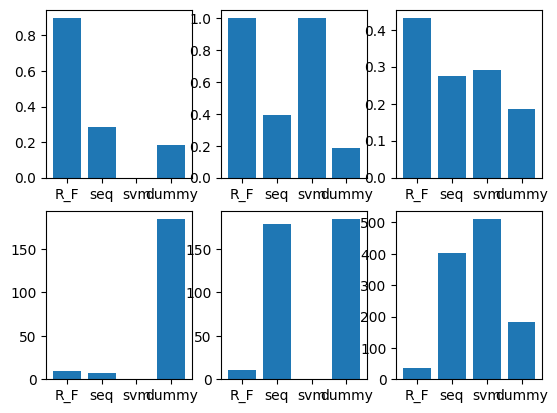

In [214]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].bar(["R_F", "seq", "svm", "dummy"], [random_forest_score_1, sequential_score_1, svm_score_1, dummy_score_1])
print("wykres 1:1 -prawdziwie pozytywne/ wszystkie pozytywne z usuniętymi brakującymi wartościami")
axs[0, 1].bar(["R_F", "seq", "svm", "dummy"], [random_forest_score_2, sequential_score_2, svm_score_2, dummy_score_1])
print("wykres 1:2 -prawdziwie pozytywne/ wszystkie pozytywne z uzupełnionymi brakującymi wartościami")
axs[0, 2].bar(["R_F", "seq", "svm", "dummy"], [random_forest_score_3, sequential_score_3, svm_score_3, dummy_score_1])
print("wykres 1:3 -prawdziwie pozytywne/ wszystkie pozytywne z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami")
count_rf = random_forest_cm_1[1][1]+random_forest_cm_1[0][1]
count_seq = sequential_cm_1[1][1]+sequential_cm_1[0][1]
count_svm = svm_cm_1[1][1]+svm_cm_1[0][1]
count_dummy = dummy_cm_1[1][1]+dummy_cm_1[0][1]
axs[1,0].bar(["R_F", "seq", "svm", "dummy"], [count_rf, count_seq, count_svm, count_dummy])
print("wykres 2:1 -wszystkie pozytywne:")
print(count_rf, count_seq, count_svm, count_dummy)
count_rf = random_forest_cm_2[1][1]+random_forest_cm_2[0][1]
count_seq = sequential_cm_2[1][1]+sequential_cm_2[0][1]
count_svm = svm_cm_2[1][1]+svm_cm_2[0][1]
axs[1,1].bar(["R_F", "seq", "svm", "dummy"], [count_rf, count_seq, count_svm, count_dummy])
print("wykres 2:2 -wszystkie pozytywne:")
print(count_rf, count_seq, count_svm, count_dummy)
count_rf = random_forest_cm_3[1][1]+random_forest_cm_3[0][1]
count_seq = sequential_cm_3[1][1]+sequential_cm_3[0][1]
count_svm = svm_cm_3[1][1]+svm_cm_3[0][1]
axs[1,2].bar(["R_F", "seq", "svm", "dummy"], [count_rf, count_seq, count_svm, count_dummy])
print("wykres 2:3 -wszystkie pozytywne:")
print(count_rf, count_seq, count_svm, count_dummy)


In [217]:
print("macierze pomyłek: ")
print("las losowy z usunietymi brakujacymi wartościami: ")
print(random_forest_cm_1)
print("las losowy z uzupełnionymi brakującymi wartościami: ")
print(random_forest_cm_2)
print("las losowy z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: ")
print(random_forest_cm_3)
print("model oparty o sieć sekwencyjną z usunietymi brakujacymi wartościami: ")
print(sequential_cm_1)
print("model oparty o sieć sekwencyjną z uzupełnionymi brakującymi wartościami: ")
print(sequential_cm_2)
print("model oparty o sieć sekwencyjną z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: ")
print(sequential_cm_3)
print("SVM z usunietymi brakujacymi wartościami: ")
print(svm_cm_1)
print("SVM z uzupełnionymi brakującymi wartościami: ")
print(svm_cm_2)
print("SVM z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: ")
print(svm_cm_3)

macierze pomyłek: 
las losowy z usunietymi brakujacymi wartościami: 
[[907   1]
 [181   9]]
las losowy z uzupełnionymi brakującymi wartościami: 
[[1048    0]
 [ 198   11]]
las losowy z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: 
[[1023   21]
 [ 197   16]]
model oparty o sieć sekwencyjną z usunietymi brakujacymi wartościami: 
[[903   5]
 [188   2]]
model oparty o sieć sekwencyjną z uzupełnionymi brakującymi wartościami: 
[[940 109]
 [138  70]]
model oparty o sieć sekwencyjną z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: 
[[745 292]
 [109 111]]
SVM z usunietymi brakujacymi wartościami: 
[[906   0]
 [192   0]]
SVM z uzupełnionymi brakującymi wartościami: 
[[1016    0]
 [ 241    0]]
SVM z uzupełnionymi brakującymi wartościami i zbalansowanymi klasami: 
[[667 362]
 [ 80 148]]


In [215]:
"""powyższe wyniki pokazują że użycie modeli może zwiekszyć szanse na znalezienie partnera,
Jednak skuteczny model będzie potrzebował bardzo dużej bazy potencjalnych randek aby wskazać taką,
która ma szanse na powodzenie. To sprawia, że w większości przypadków model może okazać się niemożliwy do praktycznego wdrożenia"""

'powyższe wyniki pokazują że użycie modeli może zwiekszyć szanse na znalezienie partnera,\nJednak skuteczny model będzie potrzebował bardzo dużej bazy potencjalnych randek aby wskazać taką,\nktóra ma szanse na powodzenie. To sprawia, że w większości przypadków model może okazać się niemożliwy do praktycznego wdrożenia'